Checking directory structure:
total 12
drwx------ 2 root root 4096 Apr 17 15:01 Potato___Early_blight
drwx------ 2 root root 4096 Apr 17 15:01 Potato___healthy
drwx------ 2 root root 4096 Apr 17 15:01 Potato___Late_blight
Found 2159 files belonging to 3 classes.
Using 1728 files for training.
Found 2159 files belonging to 3 classes.
Using 431 files for validation.
Ohaiyoo!! Total 3 Classes
index 0 contains Potato___Early_blight
index 1 contains Potato___Late_blight
index 2 contains Potato___healthy
Number of training batches: 54
Number of validation batches: 14
Training with 54 steps per epoch and 14 validation steps
Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 465s 2s/step - accuracy: 0.5579 - loss: 1.9648 - val_accuracy: 0.8353 - val_loss: 0.4682
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8542 - loss: 0.3760 - val_accuracy: 0.9049 - val_loss: 0.2367
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9346 - loss: 0.1912 - val_accuracy: 0.9188 - val_loss: 0

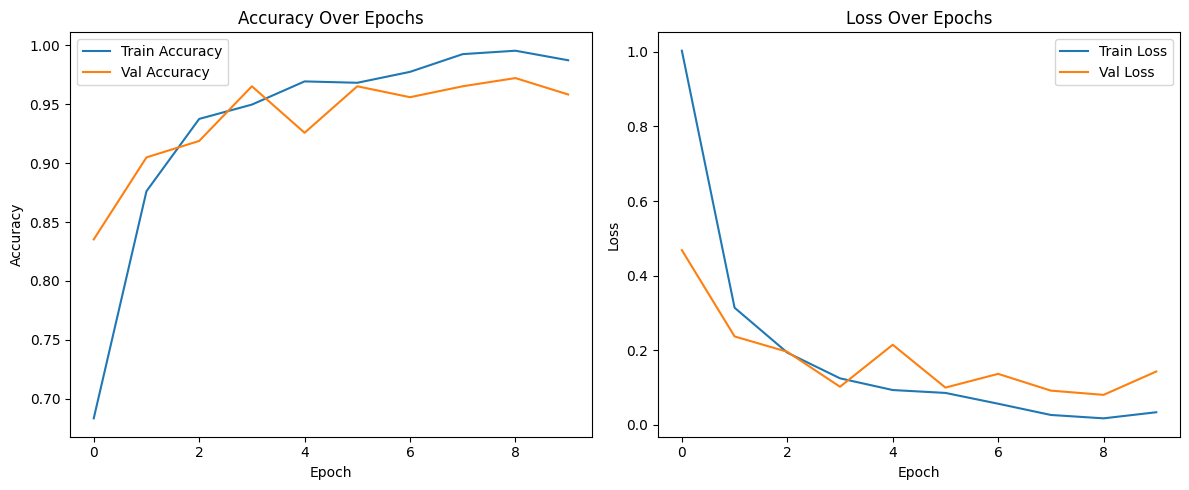

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9647 - loss: 0.1304
Validation Accuracy: 0.9582366347312927


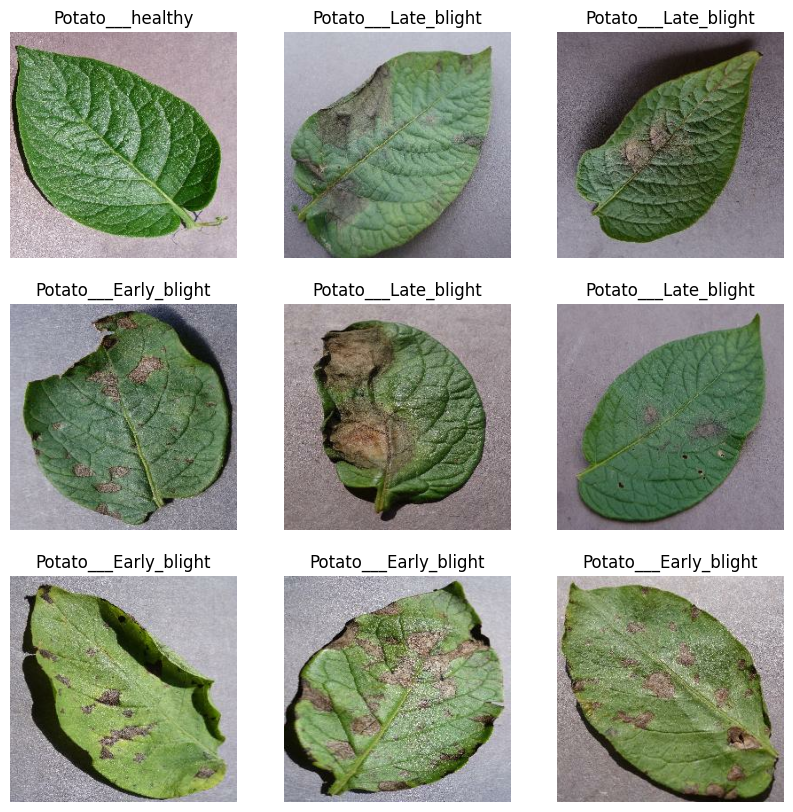

Visualizing training data samples:


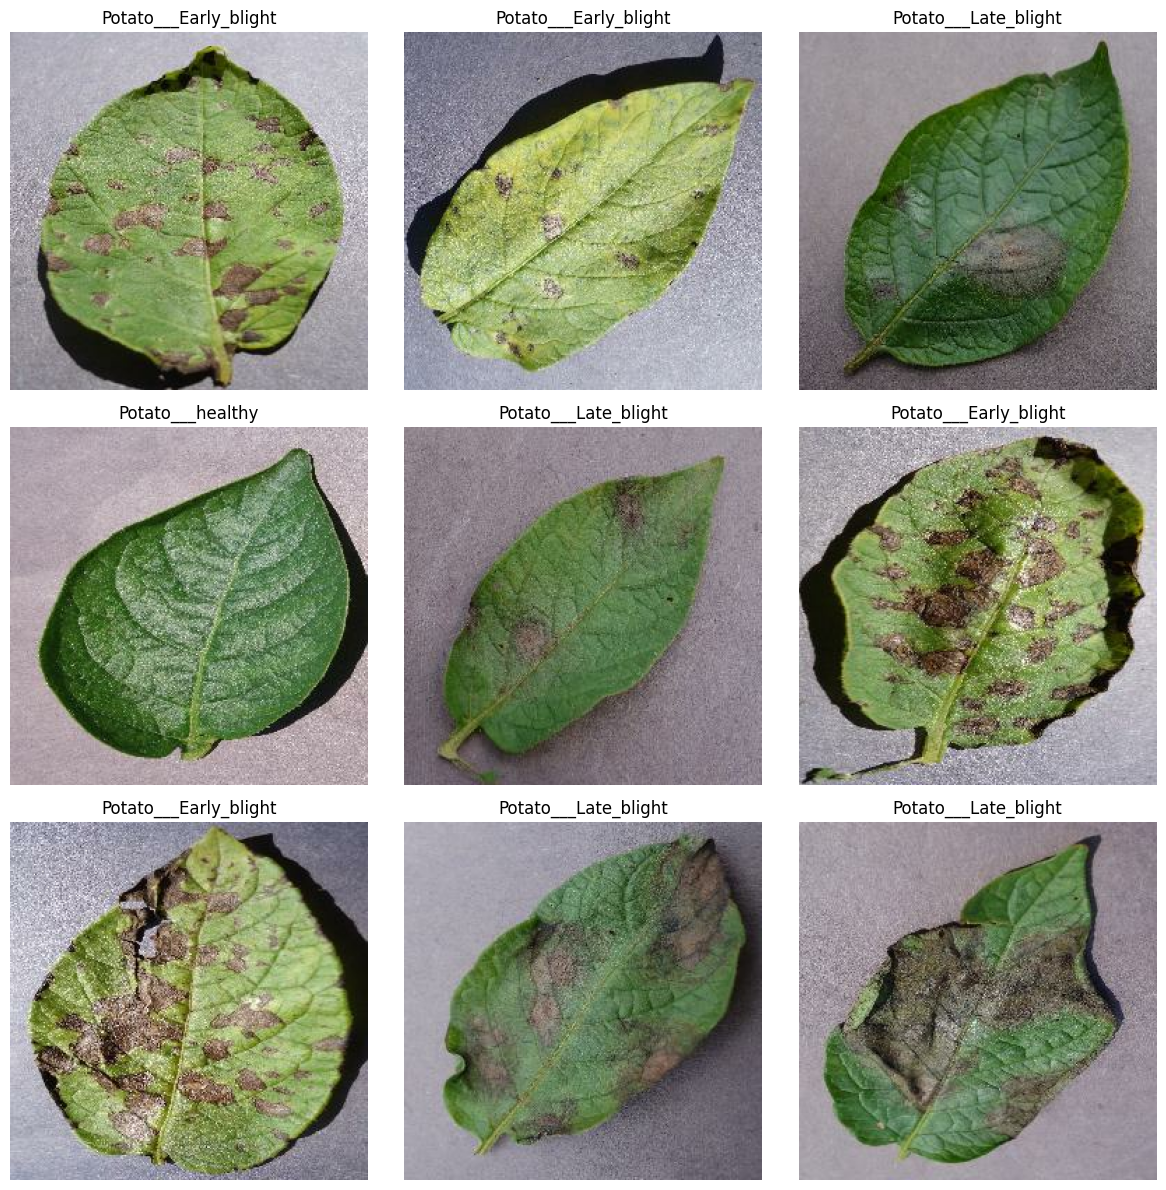

In [ ]:

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import numpy as np

print("Checking directory structure:")
!ls -la "/content/drive/MyDrive/Plant village"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Plant village",
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=(256, 256),
    batch_size=32
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Plant village",
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=(256, 256),
    batch_size=32
)

class_names = train_dataset.class_names
print("Ohaiyoo!! Total", len(class_names), "Classes")
for i in range(len(class_names)):
    print("index", i, "contains", class_names[i])

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_dataset.cache().shuffle(1000).repeat().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_dataset)}")

inputs = tf.keras.Input(shape=(256, 256, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

if len(class_names) == 1:
    outputs = layers.Dense(1, activation='sigmoid')(x)
    loss_fn = 'binary_crossentropy'
else:
    outputs = layers.Dense(len(class_names), activation='softmax')(x)
    loss_fn = 'sparse_categorical_crossentropy'

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

steps_per_epoch = max(20, tf.data.experimental.cardinality(train_dataset).numpy())
validation_steps = max(5, tf.data.experimental.cardinality(validation_dataset).numpy())

print(f"Training with {steps_per_epoch} steps per epoch and {validation_steps} validation steps")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.tight_layout()
plt.show()

loss, accuracy = model.evaluate(val_ds)
print("Validation Accuracy:", accuracy)

for image_batch, label_batch in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(image_batch))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    plt.show()

model.save('plant_disease_model.h5')

def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(256, 256)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    if len(class_names) == 1:
        confidence = float(predictions[0][0])
        predicted_class = class_names[0] if confidence > 0.5 else "normal"
        result_text = f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}"
    else:
        predicted_index = tf.argmax(predictions[0])
        predicted_class = class_names[predicted_index]
        confidence = float(tf.reduce_max(predictions[0]))
        result_text = f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}"

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(result_text)
    plt.axis("off")
    plt.show()

    return predicted_class, confidence

def visualize_dataset(dataset, class_names, num_images=9):
    """Display a grid of images from the dataset"""
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(min(num_images, len(images))):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if len(class_names) == 1:
                class_label = class_names[0] if labels[i] == 1 else "normal"
            else:
                class_label = class_names[labels[i]]
            plt.title(class_label)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Visualizing training data samples:")
visualize_dataset(train_dataset, class_names)
